In [148]:
# Classifying Cats vs Dogs with a Convolutional Neural Network on Kaggle3

# Below model from: https://pythonprogramming.net/convolutional-neural-network-kats-vs-dogs-machine-learning-tutorial/
# Import all libraries as below
# install OpenCV for first time

# Full run through of raw images to classification with Convolutional Neural Network : Dogs Vs Cats
# Package Requirements
#numpy (pip install numpy) tqdm (pip install tqdm)
#I will be using the GPU version of TensorFlow along with tflearn.

#To install the CPU version of TensorFlow, just do pip install tensorflow To install the GPU version of TensorFlow, 
# you need to get all the dependencies and such.

import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os 
from random import shuffle
import cv2
%matplotlib inline

In [149]:
# Copy test and train datasets from Kaggle into the local PC and provide the pat of Test and Train Directories as below

#Once you have downloaded and extracted the data from https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data, 
# you're ready to begin.

# We've got the data, but we can't exactly just stuff raw images right through our convolutional neural network. 
# First, we need all of the images to be the same size, and then we also will probably want to just grayscale them. 
# Also, the labels of "cat" and "dog" are not useful, we want them to be one-hot arrays.

# TensorFlow Fold makes it easy to implement deep-learning models that operate over data of varying size and structure."

# Fascinating...but, for now, we'll do it the old fashioned way.

TEST_DIR = "E:/IIM/TensorFlow/test"
TRAIN_DIR = "E:/IIM/TensorFlow/train"

In [165]:
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscat-{}-{}.model'.format(LR, '2conv-basic')
# just so we remember which saved model is which, sizes must match

In [166]:
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #                            [much cat, no dog]
    if word_label == 'cat': return [1,0]
    #                             [no cat, very doggo]
    elif word_label == 'dog': return [0,1]

In [167]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [168]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [169]:
train_data = create_train_data()
# If you have already created the dataset:
#train_data = np.load('train_data.npy')

100%|██████████| 25000/25000 [00:24<00:00, 1032.09it/s]


In [170]:
#Next, we're ready to define our neural network:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression


In [171]:
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

In [172]:
# normalisation of images
img_prep = ImagePreprocessing()
img_prep.add_featurewise_zero_center()
img_prep.add_featurewise_stdnorm()

# Create extra synthetic training data by flipping & rotating images
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_rotation(max_angle=25.)

In [173]:
#convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input',data_preprocessing=img_prep, data_augmentation=img_aug)
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

In [174]:
import tensorflow as tf
tf.reset_default_graph()

In [175]:

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [176]:
#model = tflearn.DNN(convnet, tensorboard_dir='log')
#What we have here is a nice, 2 layered convolutional neural network, with a fully connected layer, 
# and then the output layer. It's been debated whether or not a fully connected layer is of any use. 
# I'll leave it in anyway. 

In [177]:
#This exact convnet was good enough for recognizing hand 28x28 written digits. 
# Let's see how it does with cats and dogs at 50x50 resolution.

In [178]:
# Now, it wont always be the case that you're training the network fresh every time. 
# Maybe first you just want to see how 3 epochs trains, but then, after 3, maybe you're done, 
# or maybe you want to see about 5 epochs. We want to be saving our model after every session, and reloading it
# if we have a saved version, so I will add this:

In [179]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [180]:
#Now, let's split out training and testing data:

train = train_data[:-500]
test = train_data[-500:]

Now, the training data and testing data are both labeled datasets. The training data is what we'll fit the neural network with, and the test data is what we're going to use to validate the results. The test data will be "out of sample," meaning the testing data will only be used to test the accuracy of the network, not to train it.

We also have "test" images that we downloaded. THOSE images are not labeled at all, and those are what we'll submit to Kaggle for the competition.

Next, we're going to create our data arrays. For some reason, typical numpy logic like:

array[:,0] and array[:,1] did NOT work for me here. Not sure what I'm doing wrong, so I do this instead to separate my features and labels:

In [181]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

In [182]:
test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [183]:
# Now we fit for 3 epochs:

model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1148  | total loss: 11.28032 | time: 45.181s
| Adam | epoch: 003 | loss: 11.28032 - acc: 0.5101 -- iter: 24448/24500
Training Step: 1149  | total loss: 11.05173 | time: 46.298s
| Adam | epoch: 003 | loss: 11.05173 - acc: 0.5200 | val_loss: 11.60503 - val_acc: 0.4960 -- iter: 24500/24500
--


In [184]:
#Training Step: 1148  | total loss: 11.40617 | time: 59.952s
#| Adam | epoch: 003 | loss: 11.40617 - acc: 0.5046 -- iter: 24448/24500
#Training Step: 1149  | total loss: 11.12902 | time: 61.102s
#| Adam | epoch: 003 | loss: 11.12902 - acc: 0.5167 | val_loss: 11.60503 - val_acc: 0.4960 -- iter: 24500/24500
#--

In [185]:
# It doesn't look like we've gotten anywhere at all.

#We could keep trying, but, if you haven't made accuracy progress in the first 3 epochs, you're probably not going to at all, 
#unless it's due to overfitment...at least in my experience.

#So... now what?
#  Size Matters¶
#We're gonna need a bigger network

#First, we need to reset the graph instance, since we're doing this in a continuous environment:

In [186]:
import tensorflow as tf
tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')


In [187]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-500]
test = train_data[-500:]

In [188]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [189]:
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1148  | total loss: 0.46682 | time: 48.637s
| Adam | epoch: 003 | loss: 0.46682 - acc: 0.7670 -- iter: 24448/24500
Training Step: 1149  | total loss: 0.47207 | time: 49.767s
| Adam | epoch: 003 | loss: 0.47207 - acc: 0.7668 | val_loss: 0.56626 - val_acc: 0.7340 -- iter: 24500/24500
--


In [190]:
#Training Step: 1148  | total loss: 0.46025 | time: 63.884s
#| Adam | epoch: 003 | loss: 0.46025 - acc: 0.7903 -- iter: 24448/24500
#Training Step: 1149  | total loss: 0.45743 | time: 65.061s
#| Adam | epoch: 003 | loss: 0.45743 - acc: 0.7925 | val_loss: 0.50954 - val_acc: 0.7200 -- iter: 24500/24500
#--

In [191]:
#WELL WELL WELL... Looks like we've got a winner. With neural networks, size matters a ton. We went from having apparently 
# un-trainable data to having obviously trainable data, and this was only 3 epochs.

#If you are happy with the model, go ahead and save it:

In [192]:
model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\Eshwar\dogsvscat-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


In [193]:
# INFO:tensorflow:C:\Users\Eshwar\dogsvscats-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.

In [194]:
#Now we can reload the model, and continue training (we don't NEED to reload the model here since this is continuous 
# and the model is still in memory, but if you were running this as a program you would)

In [195]:
import tensorflow as tf
tf.reset_default_graph()

In [196]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')


In [197]:
model = tflearn.DNN(convnet, tensorboard_dir='log')

In [198]:
if os.path.exists('C:/Users/Eshwar/{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 4978  | total loss: 0.28048 | time: 49.960s
| Adam | epoch: 010 | loss: 0.28048 - acc: 0.8810 -- iter: 24448/24500
Training Step: 4979  | total loss: 0.26559 | time: 51.110s
| Adam | epoch: 010 | loss: 0.26559 - acc: 0.8882 | val_loss: 0.61053 - val_acc: 0.7820 -- iter: 24500/24500
--


In [199]:
#Training Step: 4978  | total loss: 0.21391 | time: 59.366s
#| Adam | epoch: 010 | loss: 0.21391 - acc: 0.9139 -- iter: 24448/24500
#Training Step: 4979  | total loss: 0.20713 | time: 60.525s
#| Adam | epoch: 010 | loss: 0.20713 - acc: 0.9147 | val_loss: 0.62615 - val_acc: 0.7920 -- iter: 24500/24500
#--

In [200]:
# You can be too big.
#Bigger is not always better, there does get to be a limit, at least from my experience.
# A bigger network figures things out better, and quicker, but tends to also overfit the training data. 
# You can use dropout (sets randomly a certain % of nodes to not take part in the network for more robusts networks)
# to rectify this slightly, but there does seem to be a limit.

# Okay, now what? Let's see how we've done!

In [201]:
# Visually inspecting our network against unlabeled data

100%|██████████| 12500/12500 [00:28<00:00, 436.31it/s]


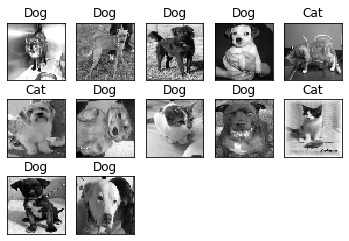

In [202]:
import matplotlib.pyplot as plt

# if you need to create the data:
test_data = process_test_data()
# if you already have some saved: Yes, saved in below fplder
#test_data = np.load('C:/User/Eshwar/test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,5,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

Alright, so we made a couple of mistakes, but not too bad actually!

If you're happy with it, let's compete!

In [203]:
with open('DogVsCatsubmission_file.csv','w') as f:
    f.write('id,label\n')
            
with open('DogVsCatsubmission_file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))

100%|██████████| 12500/12500 [00:22<00:00, 561.00it/s]


In [102]:
# 100%|██████████| 12500/12500 [00:22<00:00, 558.22it/s]

In [ ]:
THE END